In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1237 - acc: 0.4297
Epoch 00001: val_loss improved from inf to 1.79838, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_3_conv_checkpoint/001-1.7984.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 2.1241 - acc: 0.4296 - val_loss: 1.7984 - val_acc: 0.4468
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0594 - acc: 0.6929
Epoch 00002: val_loss improved from 1.79838 to 1.72925, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_3_conv_checkpoint/002-1.7293.hdf5
36805/36805 [==============================] - 29s 789us/sample - loss: 1.0595 - acc: 0.6929 - val_loss: 1.7293 - val_acc: 0.5483
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6208 - acc: 0.8138
Epoch 00003: val_loss improved from 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9896
Epoch 00028: val_loss did not improve from 1.69668
36805/36805 [==============================] - 30s 802us/sample - loss: 0.0507 - acc: 0.9896 - val_loss: 3.1702 - val_acc: 0.5511
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9883
Epoch 00029: val_loss did not improve from 1.69668
36805/36805 [==============================] - 29s 799us/sample - loss: 0.0507 - acc: 0.9883 - val_loss: 3.3406 - val_acc: 0.5530
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9910
Epoch 00030: val_loss did not improve from 1.69668
36805/36805 [==============================] - 30s 802us/sample - loss: 0.0438 - acc: 0.9909 - val_loss: 3.1565 - val_acc: 0.5511
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9823
Epoch 00031: val_loss did not improve from 1.69668
36805/36805 [==================

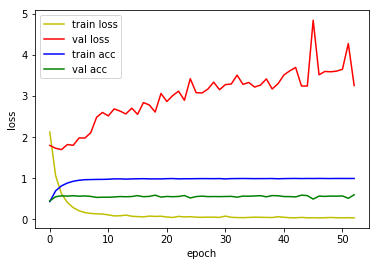

4815/4815 [==============================] - 2s 410us/sample - loss: 1.7964 - acc: 0.5445
Loss: 1.7964190778207432 Accuracy: 0.5445483

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9270 - acc: 0.4248
Epoch 00001: val_loss improved from inf to 1.70415, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_4_conv_checkpoint/001-1.7042.hdf5
36805/36805 [==============================] - 34s 923us/sample - loss: 1.9262 - acc: 0.4250 - val_loss: 1.7042 - val_acc: 0.4601
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2044 - acc: 0.6380
Epoch 00002: val_loss improved from 1.70415 to 1.26230, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_4_conv_checkpoint/002-1.2623.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 1.2040 - acc: 0.6383 - val_loss: 1.2623 - val_acc: 0.6219
Epoch 3/500
36736/36805 [====================

36736/36805 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9918
Epoch 00028: val_loss did not improve from 1.13888
36805/36805 [==============================] - 29s 793us/sample - loss: 0.0484 - acc: 0.9917 - val_loss: 1.6579 - val_acc: 0.6608
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9931
Epoch 00029: val_loss did not improve from 1.13888
36805/36805 [==============================] - 29s 798us/sample - loss: 0.0427 - acc: 0.9931 - val_loss: 1.6473 - val_acc: 0.6643
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9924
Epoch 00030: val_loss did not improve from 1.13888
36805/36805 [==============================] - 29s 791us/sample - loss: 0.0457 - acc: 0.9923 - val_loss: 1.8210 - val_acc: 0.6359
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9920
Epoch 00031: val_loss did not improve from 1.13888
36805/36805 [==================

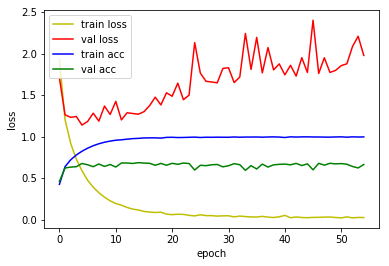

4815/4815 [==============================] - 2s 414us/sample - loss: 1.2226 - acc: 0.6407
Loss: 1.2226354261053685 Accuracy: 0.6407061

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9077 - acc: 0.4155
Epoch 00001: val_loss improved from inf to 1.65186, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_5_conv_checkpoint/001-1.6519.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9077 - acc: 0.4156 - val_loss: 1.6519 - val_acc: 0.4621
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2267 - acc: 0.6248
Epoch 00002: val_loss improved from 1.65186 to 1.19720, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_5_conv_checkpoint/002-1.1972.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 1.2267 - acc: 0.6248 - val_loss: 1.1972 - val_acc: 0.6382
Epoch 3/500
36800/36805 [======================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9718
Epoch 00026: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 843us/sample - loss: 0.1281 - acc: 0.9718 - val_loss: 0.8564 - val_acc: 0.7939
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9734
Epoch 00027: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 839us/sample - loss: 0.1180 - acc: 0.9733 - val_loss: 0.7835 - val_acc: 0.8053
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9780
Epoch 00028: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 842us/sample - loss: 0.1055 - acc: 0.9780 - val_loss: 0.8641 - val_acc: 0.7987
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1083 - acc: 0.9763
Epoch 00029: val_loss did not improve from 0.75423
36805/36805 [=====

Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9931
Epoch 00056: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 840us/sample - loss: 0.0403 - acc: 0.9931 - val_loss: 0.9973 - val_acc: 0.7939
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 843us/sample - loss: 0.0383 - acc: 0.9933 - val_loss: 0.9137 - val_acc: 0.8074
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9947
Epoch 00058: val_loss did not improve from 0.75423
36805/36805 [==============================] - 31s 843us/sample - loss: 0.0350 - acc: 0.9947 - val_loss: 0.9557 - val_acc: 0.8064
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9954
Epoch 00059: val_loss did not improve from 0.75423
36805/36805 [=====

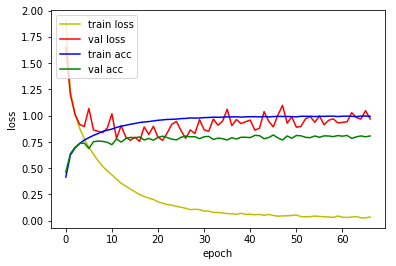

4815/4815 [==============================] - 2s 470us/sample - loss: 0.8492 - acc: 0.7556
Loss: 0.8491813025989513 Accuracy: 0.75555557

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9420 - acc: 0.4040
Epoch 00001: val_loss improved from inf to 1.63147, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_6_conv_checkpoint/001-1.6315.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.9419 - acc: 0.4040 - val_loss: 1.6315 - val_acc: 0.4533
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2340 - acc: 0.6239
Epoch 00002: val_loss improved from 1.63147 to 1.09482, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_6_conv_checkpoint/002-1.0948.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 1.2341 - acc: 0.6239 - val_loss: 1.0948 - val_acc: 0.6657
Epoch 3/500
36800/36805 [=====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1333 - acc: 0.9661
Epoch 00024: val_loss improved from 0.38855 to 0.37362, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_6_conv_checkpoint/024-0.3736.hdf5
36805/36805 [==============================] - 32s 872us/sample - loss: 0.1334 - acc: 0.9661 - val_loss: 0.3736 - val_acc: 0.8975
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9679
Epoch 00025: val_loss did not improve from 0.37362
36805/36805 [==============================] - 32s 865us/sample - loss: 0.1258 - acc: 0.9679 - val_loss: 0.3863 - val_acc: 0.8938
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9689
Epoch 00026: val_loss did not improve from 0.37362
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1236 - acc: 0.9688 - val_loss: 0.4014 - val_acc: 0.8887
Epoch 27/500
36800/36805 [============================>.

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9917
Epoch 00053: val_loss did not improve from 0.36410
36805/36805 [==============================] - 31s 855us/sample - loss: 0.0396 - acc: 0.9917 - val_loss: 0.4045 - val_acc: 0.9080
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9961
Epoch 00054: val_loss did not improve from 0.36410
36805/36805 [==============================] - 32s 857us/sample - loss: 0.0261 - acc: 0.9961 - val_loss: 0.4166 - val_acc: 0.9036
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9945
Epoch 00055: val_loss did not improve from 0.36410
36805/36805 [==============================] - 32s 863us/sample - loss: 0.0305 - acc: 0.9944 - val_loss: 0.4980 - val_acc: 0.8817
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.36410
36805/36805 [=====

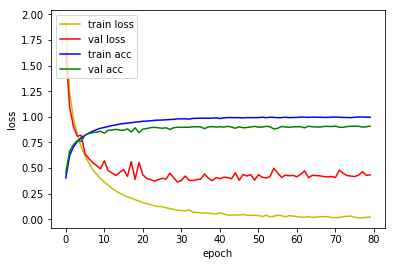

4815/4815 [==============================] - 2s 476us/sample - loss: 0.4221 - acc: 0.8810
Loss: 0.42213802426774927 Accuracy: 0.8809969

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9842 - acc: 0.3887
Epoch 00001: val_loss improved from inf to 1.87350, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_7_conv_checkpoint/001-1.8735.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.9840 - acc: 0.3887 - val_loss: 1.8735 - val_acc: 0.3485
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1259 - acc: 0.6606
Epoch 00002: val_loss improved from 1.87350 to 0.91888, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_7_conv_checkpoint/002-0.9189.hdf5
36805/36805 [==============================] - 33s 897us/sample - loss: 1.1259 - acc: 0.6606 - val_loss: 0.9189 - val_acc: 0.7305
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1104 - acc: 0.9707
Epoch 00023: val_loss did not improve from 0.23911
36805/36805 [==============================] - 34s 923us/sample - loss: 0.1104 - acc: 0.9707 - val_loss: 0.2892 - val_acc: 0.9159
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1051 - acc: 0.9722
Epoch 00024: val_loss improved from 0.23911 to 0.23097, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_7_conv_checkpoint/024-0.2310.hdf5
36805/36805 [==============================] - 34s 926us/sample - loss: 0.1051 - acc: 0.9722 - val_loss: 0.2310 - val_acc: 0.9345
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9721
Epoch 00025: val_loss did not improve from 0.23097
36805/36805 [==============================] - 34s 920us/sample - loss: 0.1002 - acc: 0.9721 - val_loss: 0.2532 - val_acc: 0.9315
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9957
Epoch 00052: val_loss did not improve from 0.23097
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0224 - acc: 0.9957 - val_loss: 0.2907 - val_acc: 0.9259
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9952
Epoch 00053: val_loss did not improve from 0.23097
36805/36805 [==============================] - 33s 904us/sample - loss: 0.0242 - acc: 0.9951 - val_loss: 0.2519 - val_acc: 0.9334
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9919
Epoch 00054: val_loss did not improve from 0.23097
36805/36805 [==============================] - 33s 888us/sample - loss: 0.0333 - acc: 0.9919 - val_loss: 0.2390 - val_acc: 0.9364
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9967
Epoch 00055: val_loss did not improve from 0.23097
36805/36805 [==================

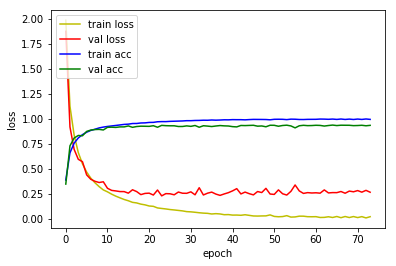

4815/4815 [==============================] - 2s 492us/sample - loss: 0.2937 - acc: 0.9144
Loss: 0.2936535029860672 Accuracy: 0.9144341

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9187 - acc: 0.4046
Epoch 00001: val_loss improved from inf to 1.56539, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_8_conv_checkpoint/001-1.5654.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.9186 - acc: 0.4046 - val_loss: 1.5654 - val_acc: 0.5071
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9813 - acc: 0.7078
Epoch 00002: val_loss improved from 1.56539 to 0.72882, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_BN_8_conv_checkpoint/002-0.7288.hdf5
36805/36805 [==============================] - 34s 927us/sample - loss: 0.9813 - acc: 0.7078 - val_loss: 0.7288 - val_acc: 0.7897
Epoch 3/500
36800/36805 [======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9794
Epoch 00025: val_loss did not improve from 0.17246
36805/36805 [==============================] - 34s 919us/sample - loss: 0.0733 - acc: 0.9794 - val_loss: 0.1837 - val_acc: 0.9434
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9824
Epoch 00026: val_loss did not improve from 0.17246
36805/36805 [==============================] - 34s 923us/sample - loss: 0.0673 - acc: 0.9824 - val_loss: 0.1779 - val_acc: 0.9474
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9837
Epoch 00027: val_loss did not improve from 0.17246
36805/36805 [==============================] - 34s 920us/sample - loss: 0.0618 - acc: 0.9837 - val_loss: 0.1806 - val_acc: 0.9476
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9839
Epoch 00028: val_loss did not improve from 0.17246
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9949
Epoch 00054: val_loss did not improve from 0.16836
36805/36805 [==============================] - 34s 929us/sample - loss: 0.0196 - acc: 0.9948 - val_loss: 0.2012 - val_acc: 0.9499
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9945
Epoch 00055: val_loss did not improve from 0.16836
36805/36805 [==============================] - 34s 922us/sample - loss: 0.0218 - acc: 0.9945 - val_loss: 0.2121 - val_acc: 0.9446
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9949
Epoch 00056: val_loss did not improve from 0.16836
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0205 - acc: 0.9949 - val_loss: 0.2070 - val_acc: 0.9509
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9981
Epoch 00057: val_loss did not improve from 0.16836
36805/36805 [==================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9919
Epoch 00084: val_loss did not improve from 0.16836
36805/36805 [==============================] - 35s 940us/sample - loss: 0.0277 - acc: 0.9919 - val_loss: 0.2158 - val_acc: 0.9515
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9988
Epoch 00085: val_loss did not improve from 0.16836
36805/36805 [==============================] - 34s 919us/sample - loss: 0.0066 - acc: 0.9988 - val_loss: 0.2017 - val_acc: 0.9529
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9993
Epoch 00086: val_loss did not improve from 0.16836
36805/36805 [==============================] - 34s 937us/sample - loss: 0.0046 - acc: 0.9993 - val_loss: 0.2336 - val_acc: 0.9418
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.16836
36805/36805 [=====

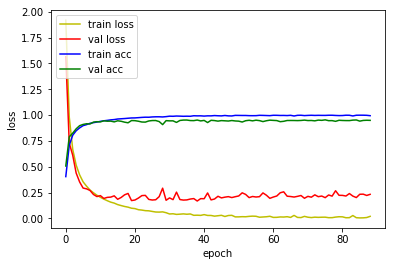

4815/4815 [==============================] - 3s 547us/sample - loss: 0.2769 - acc: 0.9265
Loss: 0.2769464774542756 Accuracy: 0.92647976



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 529us/sample - loss: 1.2226 - acc: 0.6407
Loss: 1.2226354261053685 Accuracy: 0.6407061

1D_CNN_custom_multi_2_concat_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 591us/sample - loss: 0.4221 - acc: 0.8810
Loss: 0.42213802426774927 Accuracy: 0.8809969

1D_CNN_custom_multi_2_concat_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 3s 605us/sample - loss: 0.2769 - acc: 0.9265
Loss: 0.2769464774542756 Accuracy: 0.92647976


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 663us/sample - loss: 2.1882 - acc: 0.6274
Loss: 2.1882454512151477 Accuracy: 0.62741435

1D_CNN_custom_multi_2_concat_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activ

4815/4815 [==============================] - 3s 723us/sample - loss: 0.5103 - acc: 0.8852
Loss: 0.510264226555948 Accuracy: 0.88515055

1D_CNN_custom_multi_2_concat_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 4s 778us/sample - loss: 0.3422 - acc: 0.9252
Loss: 0.3422230884525635 Accuracy: 0.92523366
